In this project we are going to classify whether a species of Iris flower is **Setosa**, **Virginica** or **Versicolour**. The dataset for this project is collected from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/iris). There are 150 rows and 5 columns in this dataset, 4 columns are the feature columns and 1 column is the target column.

The four numeric features columns are:
1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm 

and, 1 target column is:
1. species
    - Iris Setosa
    - Iris Versicolour
    - Iris Virginica



# Import libraries

In [1]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sb

import warnings
warnings.simplefilter("ignore")

In [2]:
data = pd.read_csv('../data/raw/iris.data')
data.head()

,5.1,3.5,1.4,0.2,Iris-setosa
0,4.9,3.0,1.4,0.2,Iris-setosa
1,4.7,3.2,1.3,0.2,Iris-setosa
2,4.6,3.1,1.5,0.2,Iris-setosa
3,5.0,3.6,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa


The dataset don't have any column names. So, we have to give these columns names. As, it is discussed above there are 4 feature columns **sepal-length, sepal-width, petal-length, petal-width** and 1 target column **species**.

In [3]:
data.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,4.9,3.0,1.4,0.2,Iris-setosa
1,4.7,3.2,1.3,0.2,Iris-setosa
2,4.6,3.1,1.5,0.2,Iris-setosa
3,5.0,3.6,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa


In [4]:
data.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,149.000000,149.000000,149.000000,149.000000
mean,5.848322,3.051007,3.774497,1.205369
std,0.828594,0.433499,1.759651,0.761292
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.400000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  149 non-null    float64
 1   sepal_width   149 non-null    float64
 2   petal_length  149 non-null    float64
 3   petal_width   149 non-null    float64
 4   species       149 non-null    object 
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


# Data Preparation

Check if there is any null value in the data

In [6]:
data.isnull().any().mean()

0.0

There isn't any null values in the data.
Now let's check data types of these values.

In [7]:
data.dtypes

sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
species          object
dtype: object

All the four feature columns are of **float** type but the target column is of **object** type. So, we have to convert the object type to either int or category type.

Let's change the data types of species column to **category** type

In [8]:
data['species'] = data['species'].astype('category')

In [9]:
data.dtypes

sepal_length     float64
sepal_width      float64
petal_length     float64
petal_width      float64
species         category
dtype: object

Split data into features **X** and ckass **y**

In [10]:
X = data.drop('species', axis=1)
y = data['species']

In [11]:
X.head()

,sepal_length,sepal_width,petal_length,petal_width
0,4.9,3.0,1.4,0.2
1,4.7,3.2,1.3,0.2
2,4.6,3.1,1.5,0.2
3,5.0,3.6,1.4,0.2
4,5.4,3.9,1.7,0.4


In [12]:
y.head()

0    Iris-setosa
1    Iris-setosa
2    Iris-setosa
3    Iris-setosa
4    Iris-setosa
Name: species, dtype: category
Categories (3, object): ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

### Split data into training, testing data and validation data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=1)

# Modeling

Initialize the model

In [14]:
dt_clf = DecisionTreeClassifier()
rf_clf = RandomForestClassifier()
ab_clf = AdaBoostClassifier()
gb_clf = GradientBoostingClassifier()
nb_clf = GaussianNB()
lr_clf = LogisticRegression()
sgd_clf = SGDClassifier()
knn_clf = KNeighborsClassifier()
svc_clf = SVC()

A function to train the model, predict the outcomes of the test set and then calculate the accuracy score

In [15]:
def train_predict(model):
    """
    INPUT: model
    FUNCTION: Train the model with the training data, predict the outcomes of the test data and calculate the accuracy score
    OUTPUT: accuracy score
    """
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    score = accuracy_score(y_val, pred)
    return score

The above function is used to train and test the model

In [16]:
models = [dt_clf, rf_clf, ab_clf, gb_clf, nb_clf, lr_clf, sgd_clf, knn_clf, svc_clf]
scores = {}

for model in models:
    pipe = make_pipeline(
        StandardScaler(),
        model
    )
    score = train_predict(pipe)
    scores[model.__class__.__name__] = score
scores

{'DecisionTreeClassifier': 0.9375,
 'RandomForestClassifier': 0.9375,
 'AdaBoostClassifier': 0.9375,
 'GradientBoostingClassifier': 0.9375,
 'GaussianNB': 0.8958333333333334,
 'LogisticRegression': 0.9166666666666666,
 'SGDClassifier': 0.9166666666666666,
 'KNeighborsClassifier': 0.9166666666666666,
 'SVC': 0.9375}

#### Plot the accuracy scores

In [40]:
def plot_scores(scores, fig=(19, 10)):
    fig = plt.figure(figsize=fig)
    base_color = sb.color_palette()[0]
    name = [key for key in scores.keys()]
    scor = [val for val in scores.values()]
    plots = sb.barplot(x=name, y=scor, color=base_color)
    for p in plots.patches:
        plots.annotate(format(p.get_height(), '.2f'),
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       size=15,
                       xytext = (0, -12), 
                       textcoords = 'offset points')
    plt.xlabel('Names of the Classifiers', size=18)
    plt.savefig('fig');

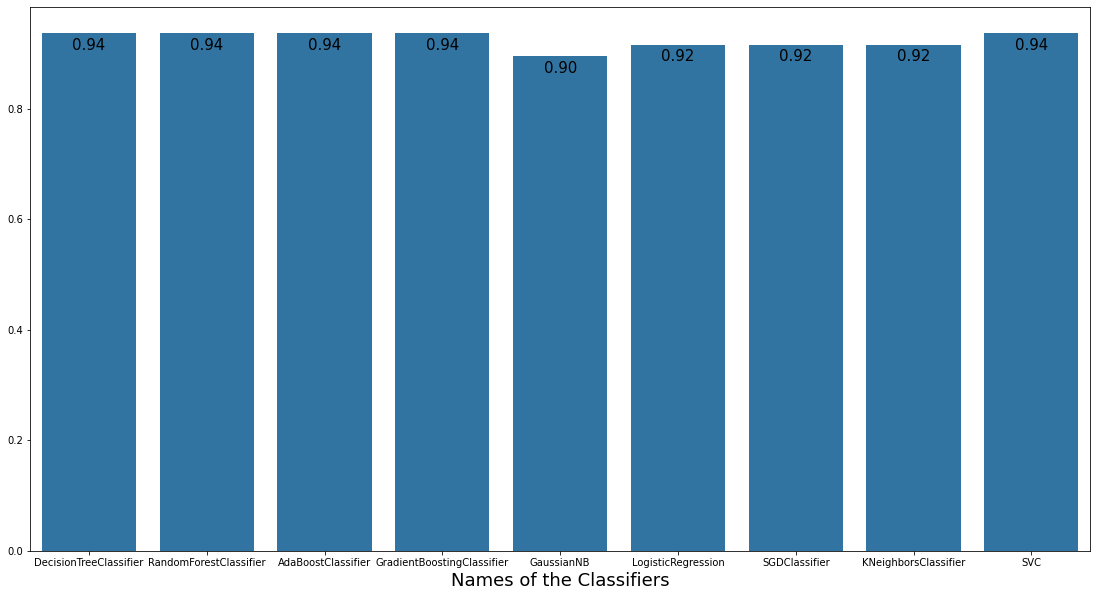

In [41]:
plot_scores(scores)

Models with the higher accuracy are:
- AdaBoostClassifier
- GradientBoostingClassifier
- SVC

So, let's optimise these classifiers to increase the accuracy

#### Set the parameters for RandomizedSearchCV

In [19]:
ab_param_distribution = {
                        'n_estimators': randint(50, 500),
                        'learning_rate': [1.0, 2.5, 3.8, 4.2],
                        'random_state': randint(1, 50)
                         }

gb_param_distribution = {
                            'learning_rate': [0.5, 1.0, 1.5, 2.0],
                            'n_estimators': randint(150, 500),
                            'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae']
                        }

svc_param_distribution = {
                            'C': [1.5, 2.5, 3.0, 4.0],
                            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                            'degree': randint(3, 10),
                            'random_state': randint(1, 50)
    
                            }

Create a function and initialized the RandomizedSearchCV to search across the different parameters for the best parameters

In [20]:
def searchCV(model, params):
    """
    INPUT: model, parameters distribution
    FUNCTION: Search for the best parameters and use it with model to train and to get best results
    OUTPUT: accuracy score, best parameters for the model
    """
    search = RandomizedSearchCV(estimator=model,
                        n_iter=5,
                        param_distributions=params,
                        random_state=0)
    search.fit(X_train, y_train)
    score = search.score(X_test, y_test)
    return score, search.best_params_

Let's give our best three models to the above function to check the scores

In [21]:
new_scores = {}
best_params = {}
models = {ab_clf: ab_param_distribution, gb_clf: gb_param_distribution, svc_clf: svc_param_distribution}
for model, params in models.items():
    score, best_param = searchCV(model, params)
    new_scores[model.__class__.__name__] = score
    best_params[model.__class__.__name__] = best_param

Print the scores and the best parameters

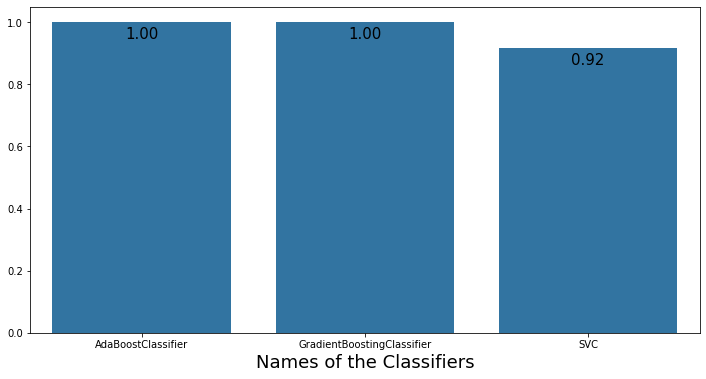

In [42]:
plot_scores(new_scores, fig=(12, 6))

After optimising the models we get the 100% accuracy in the validation set by the **AdaBoostClassifier** and **GradientBoostingClassifier**

# Model Evaluation

In [23]:
#TODO: Test the model's score with test set
#TODO: Create API for the project